## Importing Packages
Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
url = 'https://www.geonames.org/postalcode-search.html?q=barcelona&country=ES'
barcaData = pd.read_html(url)
barcaData = barcaData[2]
barcaData
barcaData = barcaData.drop(barcaData.columns[0],axis=1) 
barcaData = barcaData.drop(barcaData.columns[5:len(barcaData.columns)],axis=1).reset_index(drop=True) 
#Rename Columns
cols = list(barcaData.columns)
cols[0] = 'Neighborhood'
cols[3] = 'State'
cols[4] = 'Province'
barcaData.columns = cols
barcaData = barcaData.drop(len(barcaData.index)-1).reset_index(drop=True) 
barcaData.head()

,Neighborhood,Code,Country,State,Province
0,Barcelona,08075,Spain,Cataluna,Barcelona
1,41.389/2.159,41.389/2.159,41.389/2.159,41.389/2.159,41.389/2.159
2,Universitat Autonoma De Barcelona,08193,Spain,Cataluna,Barcelona
3,41.503/2.087,41.503/2.087,41.503/2.087,41.503/2.087,41.503/2.087
4,Bellprat,43421,Spain,Cataluna,Barcelona


## Download and Explore Dataset

In [4]:
lat = [] 
long = [] 
for count, n in enumerate(barcaData['Neighborhood']):
    if (count % 2 != 0):
        temp = n.split('/')
        lat.append(temp[0])
        long.append(temp[1])
        barcaData = barcaData.drop(count)
barcaData = barcaData.reset_index(drop=True)

#add Latitude and Logitude to LA Dataframe
data = {'Latitude':lat,'Longitude':long}
temp = pd.DataFrame(data,dtype='float')
barcaData = barcaData.join(temp)
barcaData = barcaData[barcaData['Province'].str.contains('Barcelona')] #Select only zip codes in Barca

Now lets extract the coordintes that are inserted in the form of rows and place them in new columns named as latitute and longitude

Lets us remove any duplicates for the lat and log

In [5]:
barcaData = barcaData.sort_values(by = ['Latitude','Longitude']).reset_index(drop=True)

for (row) in range(len(barcaData.index)-1):
    if barcaData.loc[row,'Latitude'] == barcaData.loc[row+1,'Latitude']:
        if barcaData.loc[row,'Longitude'] == barcaData.loc[row+1,'Longitude']:
            barcaData = barcaData.drop(row)

barcaData = barcaData.sort_values('Code').reset_index(drop=True) 

In [7]:
print('Rows:',barcaData.shape[0],'\nColumns:',barcaData.shape[1])
barcaData.head()

Rows: 112 
Columns: 7


,Neighborhood,Code,Country,State,Province,Latitude,Longitude
0,Barcelona,08080,Spain,Cataluna,Barcelona,41.389,2.159
1,Gallecs,08104,Spain,Cataluna,Barcelona,41.527,2.232
2,Martorelles,08107,Spain,Cataluna,Barcelona,41.533,2.233
3,La VallenÃ§ana,08110,Spain,Cataluna,Barcelona,41.476,2.214
4,La Llagosta,08120,Spain,Cataluna,Barcelona,41.514,2.193


Lets make sure that there is only one province : Barcelona and find out how many neighborhood is present

In [8]:
print('The dataframe has {} province and {} neighborhoods.'.format(
        len(barcaData['Province'].unique()),
        barcaData.shape[0]
    )
)

The dataframe has 1 province and 112 neighborhoods.


#### Using geopy library to getting the latitude and longitude values of Barcelona.

In [9]:
address = 'Barcelona, ES'

geolocator = Nominatim(user_agent="barca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Barcelona are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Barcelona are 41.3828939, 2.1774322.


#### Creating a map of Barclona with neighborhoods superimposed on top.

In [10]:
# create map of Barcelona using latitude and longitude values
map_barca = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, province, neighborhood in zip(barcaData['Latitude'], barcaData['Longitude'], barcaData['Province'], barcaData['Neighborhood']):
    label = '{}, {}'.format(neighborhood, province)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_barca)  
    
map_barca

#### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = '10XWDWIHUOVVVUKCELIZTCM1GAWPF4ZINPICYMOQ54CQ22FI' # your Foursquare ID
CLIENT_SECRET = '5BDHXGG5D2ADF1HSEBEJ1G2QJPA0KPXWXPDZEUCPKUU5ZJNA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 10XWDWIHUOVVVUKCELIZTCM1GAWPF4ZINPICYMOQ54CQ22FI
CLIENT_SECRET:5BDHXGG5D2ADF1HSEBEJ1G2QJPA0KPXWXPDZEUCPKUU5ZJNA


#### Now, let's get the top 100 venues that are in Barcelona within a radius of 500 meters.

In [12]:
neighborhood_latitude = barcaData.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = barcaData.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = barcaData.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Barcelona are 41.389, 2.159.


In [13]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?&client_id=10XWDWIHUOVVVUKCELIZTCM1GAWPF4ZINPICYMOQ54CQ22FI&client_secret=5BDHXGG5D2ADF1HSEBEJ1G2QJPA0KPXWXPDZEUCPKUU5ZJNA&v=20180605&ll=41.389,2.159&radius=500&limit=100'

In [14]:
results = requests.get(url).json()

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

Now we are ready to clean the json and structure it into a *pandas* dataframe

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tandem,Cocktail Bar,41.389533,2.157835
1,La Pastisseria,Pastry Shop,41.389442,2.161291
2,Robata,Japanese Restaurant,41.390551,2.158549
3,Foc i Oli,Sandwich Place,41.390034,2.156935
4,Sant Jordi Hostel Rock Palace,Hostel,41.390297,2.160753


In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## 2. Explore Neighborhoods in Barcelona

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
barca_venues = getNearbyVenues(names=barcaData['Neighborhood'],
                                   latitudes=barcaData['Latitude'],
                                   longitudes=barcaData['Longitude']
                                  )

Barcelona
Gallecs
Martorelles
La VallenÃ§ana
La Llagosta
Mogoda
Gallifa
Estany, L'
Eixample, L'
Montmelo
Collsuspina
Moia
Sentmenat
Granera
CastellterÃ§ol
Castellcir
Palau-Solita I Plegamans
Vallromanes
Rubi
Bellaterra
Colonia Puig, La (Marganell)
Sabadell
Polinya
Terrassa
Pedritxes, Les
Ullastrell
Viladecavalls
Vacarisses
Viladordis
Manresa
Castellnou De Bages
Pont De Vilumara (Manresa)
Rajadell
Fonollosa
Argensola (Castellnou De Bages)
Cardona
La Coromina
El Pala De Torroella
Navarcles
Artes
Monistrol De Calders
Calders
Talamanca
Mura
Avinyo
Calaf
Pujalt
Copons
Esparreguera
Collbato
El Bruc
Castellgali
Marganell
Rellinars
Argentona
Orrius
El Masnou
Alella
Teia
Cabrils
Calella
Palafolls
Virreina, La (Tiana)
Tiana
Can Domenec (Tordera)
Granollers
Can Diviu
Vallgorguina
Campins
Tordera
Calldetenes
Olost
Orista
Malla
Muntanyola
Centelles
Tona
Taradell
Seva
Alpens
Sora
Sobremunt
Perafita
Tagamanent
Berga
Montclar
Montmajor
Vilada
Capolat
Abrera
Cornet
Cabrianes
Balsareny
Castelladral
Giro

#### Let's check the size of the resulting dataframe

In [22]:
print(barca_venues.shape)
barca_venues.head()

(820, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barcelona,41.389,2.159,Tandem,41.389533,2.157835,Cocktail Bar
1,Barcelona,41.389,2.159,La Pastisseria,41.389442,2.161291,Pastry Shop
2,Barcelona,41.389,2.159,Robata,41.390551,2.158549,Japanese Restaurant
3,Barcelona,41.389,2.159,Foc i Oli,41.390034,2.156935,Sandwich Place
4,Barcelona,41.389,2.159,Sant Jordi Hostel Rock Palace,41.390297,2.160753,Hostel


#### Let's find out how many unique categories can be curated from all the returned venues and Let's check the size of the resulting dataframe

In [23]:
print('There are {} uniques categories.'.format(len(barca_venues['Venue Category'].unique())))

There are 147 uniques categories.


In [24]:
print(barca_venues.shape)
barca_venues.head()

(820, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barcelona,41.389,2.159,Tandem,41.389533,2.157835,Cocktail Bar
1,Barcelona,41.389,2.159,La Pastisseria,41.389442,2.161291,Pastry Shop
2,Barcelona,41.389,2.159,Robata,41.390551,2.158549,Japanese Restaurant
3,Barcelona,41.389,2.159,Foc i Oli,41.390034,2.156935,Sandwich Place
4,Barcelona,41.389,2.159,Sant Jordi Hostel Rock Palace,41.390297,2.160753,Hostel


## 3. Analyze Each Neighborhood

In [25]:
# one hot encoding
barca_onehot = pd.get_dummies(barca_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
barca_onehot['Neighborhood'] = barca_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [barca_onehot.columns[-1]] + list(barca_onehot.columns[:-1])
barca_onehot = barca_onehot[fixed_columns]

barca_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Castle,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lake,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Mountain,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Other Great Outdoors,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Ramen Restaurant,Restaurant,River,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Stadium,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vineyard,Wine Bar,Wine Shop,Women's Store
0,Barcelona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barcelona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barcelona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Barcelona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Barcelona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
barca_onehot.shape

(820, 148)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [27]:
barca_grouped = barca_onehot.groupby('Neighborhood').mean().reset_index()
barca_grouped.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Castle,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lake,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Mountain,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Other Great Outdoors,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Ramen Restaurant,Restaurant,River,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Stadium,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vineyard,Wine Bar,Wine Shop,Women's Store
0,Abrera,0.0,0.0,0.0,0.0,0.0,0.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Alella,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.066667,0.0,0.0,0.066667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0
2,Alpens,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [28]:
barca_grouped.shape

(94, 148)

#### Let's print each neighborhood along with the top 5 most common venues

In [29]:
num_top_venues = 5

for hood in barca_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = barca_grouped[barca_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abrera----
                      venue  freq
0  Mediterranean Restaurant   0.2
1        Falafel Restaurant   0.1
2        Chinese Restaurant   0.1
3               Supermarket   0.1
4                    Bakery   0.1


----Alella----
           venue  freq
0     Restaurant  0.40
1           Food  0.07
2      Wine Shop  0.07
3  Garden Center  0.07
4          Plaza  0.07


----Alpens----
                   venue  freq
0                  Diner  0.33
1  Outdoors & Recreation  0.33
2                    Bar  0.33
3           Perfume Shop  0.00
4      Paella Restaurant  0.00


----Argensola (Castellnou De Bages)----
                        venue  freq
0                         Bar  0.33
1  Tourist Information Center  0.17
2                 Bus Station  0.17
3                       Plaza  0.17
4            Tapas Restaurant  0.17


----Argentona----
          venue  freq
0  Burger Joint  0.18
1         Plaza  0.09
2          Café  0.09
3  Soccer Field  0.09
4   Snack Place  0.09


----Artes--

#### Let's put that into a *pandas* dataframe

In [69]:
barcaEncode = pd.get_dummies(barca_venues[['Venue Category']], prefix="", prefix_sep="")
barcaEncode['Neighborhood'] = barca_venues['Neighborhood']
fixed_columns = [barcaEncode.columns[-1]] + list(barcaEncode.columns[:-1])
barcaEncode = barcaEncode[fixed_columns]
barcaSorted = barcaEncode.groupby(by='Neighborhood').mean().reset_index()
barcaCluster = barcaSorted.drop('Neighborhood', axis=1)

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [97]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sort = pd.DataFrame(columns=columns)
neighborhoods_venues_sort['Neighborhood'] = barca_grouped['Neighborhood']

for ind in np.arange(barca_grouped.shape[0]):
    neighborhoods_venues_sort.iloc[ind, 1:] = return_most_common_venues(barca_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sort.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abrera,Mediterranean Restaurant,Food & Drink Shop,Sandwich Place,Supermarket,Bakery,Falafel Restaurant,Grocery Store,Chinese Restaurant,Tapas Restaurant,Women's Store
1,Alella,Restaurant,Tapas Restaurant,Food,Wine Shop,Café,Plaza,Japanese Restaurant,Gym / Fitness Center,Garden Center,Supermarket
2,Alpens,Diner,Outdoors & Recreation,Bar,Flea Market,Fried Chicken Joint,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop
3,Argensola (Castellnou De Bages),Bar,Tourist Information Center,Plaza,Tapas Restaurant,Bus Station,Dog Run,Electronics Store,Dive Bar,Falafel Restaurant,Farmers Market
4,Argentona,Burger Joint,Soccer Field,Coffee Shop,Spanish Restaurant,Gastropub,Café,Tapas Restaurant,Snack Place,Bar,Plaza


## 4. Cluster Neighborhoods

In [98]:
# set number of clusters
k = 10
kmeans = KMeans(k, random_state=0).fit(barcaCluster)

In [99]:
# add clustering labels
neighborhoods_venues_sort.insert(0,'Cluster Labels',kmeans.labels_)

In [100]:
# Join Zipcodes & Coordinates with Cluster Labels and Top Venues
barcaFinal = pd.DataFrame()
barcaFinal = barcaData.loc[:,['Province','Code','Latitude','Longitude']].sort_values(by='Code').reset_index(drop=True)
for x in barca_venues:
    if barcaFinal['Code'].str.contains(x).any():
        barcaFinal = barcaFinal.drop(barcaFinal.index[barcaFinal['Code']==x])
barcaFinal = barcaFinal.reset_index(drop=True)
barcaFinal = barcaFinal.join(neighborhoods_venues_sort)
barcaFinal = barcaFinal.sort_values('Cluster Labels').reset_index(drop=True)
barcaFinal.head(100)

,Province,Code,Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barcelona,08552,41.875,2.287,0.0,Talamanca,Restaurant,Hotel,Mediterranean Restaurant,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
1,Barcelona,08188,41.533,2.300,0.0,Can Domenec (Tordera),Restaurant,Spanish Restaurant,Fast Food Restaurant,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop
2,Barcelona,08650,41.813,1.906,0.0,Vilada,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
3,Barcelona,08297,41.569,1.881,0.0,Martorelles,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
4,Barcelona,08278,41.699,1.976,0.0,Granera,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
5,Barcelona,08243,41.725,1.827,0.0,Copons,Restaurant,Paintball Field,Women's Store,Fish & Chips Shop,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
6,Barcelona,08320,41.480,2.319,0.0,Monistrol De Calders,Restaurant,Mediterranean Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
7,Barcelona,08269,41.864,1.714,0.0,Fonollosa,Restaurant,Performing Arts Venue,Women's Store,Fast Food Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop
8,Barcelona,08529,41.883,2.183,0.0,Sobremunt,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
9,Barcelona,08471,41.648,2.510,1.0,Rajadell,Plaza,Train Station,Bar,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop


In [90]:
##### initialize map
clusterMap = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**4 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barcaFinal['Latitude'], barcaFinal['Longitude'], barcaFinal['Code'], barcaFinal['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=500,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(clusterMap)
print('K    Count\n-----------')
print(barcaFinal['Cluster Labels'].value_counts(sort=False))
display(clusterMap)

K    Count
-----------
0     18
1      9
2      5
3     21
4     34
5      3
6      1
7      1
8      7
9     12
10     1
Name: Cluster Labels, dtype: int64


In [89]:
#barcaFinal['Cluster Labels'].astype(int)

barcaFinal['Cluster Labels'] = barcaFinal['Cluster Labels'].fillna(0).astype(int)

## 5. Examine Clusters

In [91]:
barcaFinal.loc[barcaFinal['Cluster Labels'] == 1, barcaFinal.columns[[1] + list(range(5, barcaFinal.shape[1]))]]

,Code,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,08552,Talamanca,Restaurant,Hotel,Mediterranean Restaurant,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
1,08188,Can Domenec (Tordera),Restaurant,Spanish Restaurant,Fast Food Restaurant,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop
2,08650,Vilada,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
3,08297,Martorelles,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
4,08278,Granera,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
5,08243,Copons,Restaurant,Paintball Field,Women's Store,Fish & Chips Shop,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant
6,08320,Monistrol De Calders,Restaurant,Mediterranean Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
7,08269,Fonollosa,Restaurant,Performing Arts Venue,Women's Store,Fast Food Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop
8,08529,Sobremunt,Restaurant,Women's Store,Fish & Chips Shop,Fountain,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant


In [92]:
barcaFinal.loc[barcaFinal['Cluster Labels'] == 4, barcaFinal.columns[[1] + list(range(5, barcaFinal.shape[1]))]]

,Code,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,08310,Mogoda,Tapas Restaurant,Mediterranean Restaurant,Seafood Restaurant,Convenience Store,Park,Coffee Shop,Soccer Field,Women's Store,Food Truck,Food & Drink Shop
36,08329,Montmelo,Burger Joint,Spanish Restaurant,Electronics Store,Breakfast Spot,Supermarket,Train Station,Paper / Office Supplies Store,Café,Food,Fountain
37,08600,Torrelavit,Spanish Restaurant,Pool,Pub,Trail,Fast Food Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
38,08390,Palafolls,Spanish Restaurant,Women's Store,Grocery Store,Gift Shop,Mediterranean Restaurant,Plaza,Restaurant,Clothing Store,Sandwich Place,Platform
39,08294,Manresa,Café,Ice Cream Shop,Clothing Store,Plaza,Burger Joint,Cocktail Bar,Restaurant,Tapas Restaurant,Creperie,Mediterranean Restaurant
40,08593,Tordera,Breakfast Spot,Grocery Store,Dessert Shop,Café,Lake,Women's Store,Fountain,Food Truck,Food & Drink Shop,Food
41,08472,Rellinars,Fountain,Women's Store,Department Store,Fried Chicken Joint,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop
42,08588,Terrassa,Café,Grocery Store,Theater,Historic Site,Restaurant,Train Station,Tapas Restaurant,Mediterranean Restaurant,Metro Station,Castle
43,08553,Taradell,Breakfast Spot,Pub,Café,Performing Arts Venue,Women's Store,Flea Market,Food Truck,Food & Drink Shop,Food,Flower Shop
44,08506,Sabadell,Mediterranean Restaurant,Bakery,Restaurant,Ice Cream Shop,Tapas Restaurant,Pizza Place,Sandwich Place,Movie Theater,Breakfast Spot,Coffee Shop


# Exploring the Population Dataset

In [102]:
Population = pd.read_csv('Province_of_Barcelona.csv')
Population.head()

,Area,Population,Code
0,Abrera,12334.0,8001
1,Aguilar de Segarra,277.0,8002
2,Aiguafreda,2501.0,8014
3,Alella,9764.0,8003
4,Alpens,273.0,8004


In [103]:
pop_df=Population.sort_values('Population', ascending=False).head(10)
pop_df

,Area,Population,Code
20,Barcelona,1620343.0,8019
280,Terrassa,218535.0,8279
14,Badalona,217741.0,8015
192,Sabadell,211734.0,8187
127,Mataró,126988.0,8121
251,Santa Coloma de Gramenet,118821.0,8245
207,Sant Cugat del Vallès,90664.0,8205
76,Cornellà de Llobregat,87173.0,8073
202,Sant Boi de Llobregat,82904.0,8200
189,Rubí,76423.0,8184


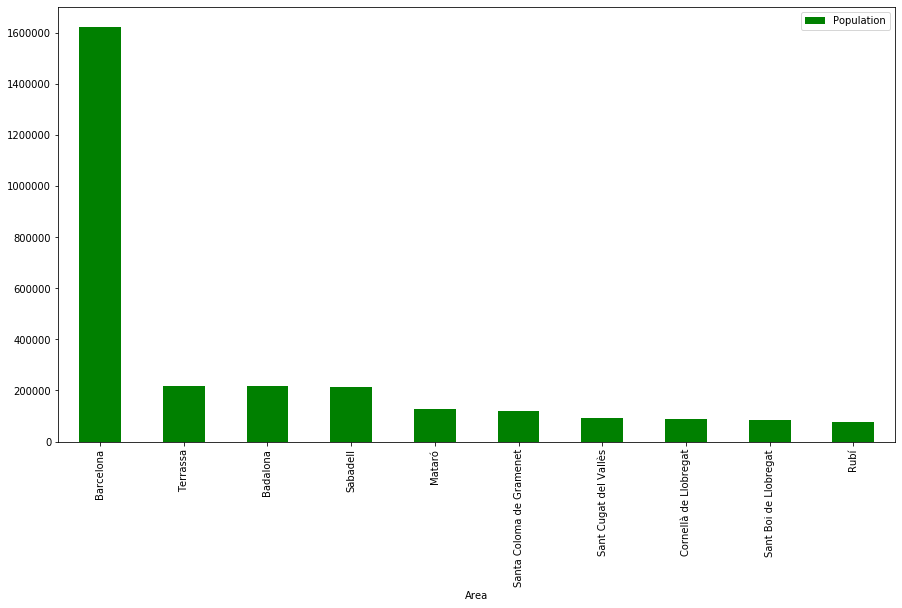

In [105]:
ax = pop_df.plot.bar(x='Area', y='Population', color="green", figsize=(15, 8))
ax